#라이브러리 및 데이터 가져오기

##라이브러리

In [ ]:
!pip install numpy==1.24.3

ERROR: Operation cancelled by user


In [ ]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2463306 sha256=ca9e5dad0085ce36a2293b63432164af9ac87896006b63a4295d463690f283bb
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
# google drive 마운트
from google.colab import drive
drive.mount('./drive')

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVDpp,accuracy,Reader, Dataset
from surprise.model_selection import cross_validate, train_test_split

##평점 데이터 불러오기

In [ ]:
#import data
import os
os.chdir('./drive/MyDrive/Colab Notebooks/Hankkimoa/kaggle_data')
rating = pd.read_csv('ratings.csv')

In [ ]:
rating

,userID,placeID,rating
0,1077,135085,2
1,1077,135038,2
2,1077,132825,2
3,1077,135060,1
4,1068,135104,1
...,...,...,...
1156,1043,132630,1
1157,1011,132715,1
1158,1068,132733,1
1159,1068,132594,1


##크롤링한 json파일에서 식당 정보 매트릭스 추출

In [ ]:
import json
import re
import pandas as pd
import numpy as np

In [ ]:
##크롤링 파일 경로 추가
#json_file_path = ""

In [ ]:
# JSON 데이터 로드 (파일에서 로드하는 경우)
def load_restaurant_data(json_file_path):
    with open(json_file_path, 'r', encoding='utf-8') as file:
        restaurant_data = json.load(file)
    return restaurant_data

In [ ]:
# 또는 JSON 문자열에서 직접 로드하는 경우
# restaurant_data = json.loads(json_string)

In [ ]:
# 샘플
restaurant_data = {
    "id": "36868623",
    "name": "명동정",
    "category": "한정식",
    "address": "서울 중구 삼일대로 299 이화빌딩 1층",
    "images": [
      "https://search.pstatic.net/common/?autoRotate=true&type=w560_sharpen&src=https%3A%2F%2Fldb-phinf.pstatic.net%2F20220723_74%2F1658580968138dECyP_JPEG%2F2.jpg",
      # 생략된 이미지들
    ],
    "openingHours": [
      {
        "dayOfWeek": "수",
        "hours": {
          "startTime": "11:30",
          "endTime": "21:30",
          "breakStartTime": "15:00",
          "breakEndTime": "17:00",
          "lastOrderTime": "20:00"
        }
      }
      # 생략된 영업시간
    ],
    "menu": [
      {
        "isMain": False,
        "name": "해신상",
        "introduce": "연평도 꽃게찜 , 전복갈비찜, 연어구이,오색대하찜등 고급한식을 위주로 구성되었습니다.",
        "price": "85,000",
        "imgUrl": "https://search.pstatic.net/common/?autoRotate=true&quality=95&type=f320_320&src=https%3A%2F%2Fldb-phinf.pstatic.net%2F20231208_44%2F1702028576507rC9aF_JPEG%2F2023_%25C7%25D8%25BD%25C5%25BB%25F3_%25B0%25A5%25BA%25F1%25C2%25F2.jpg"
      }
      # 생략된 메뉴
    ]
}

In [ ]:
# 여러 식당 데이터를 처리하는 함수
def create_restaurant_dataframe(restaurants_data):
    # 여러 식당 데이터가 리스트로 제공되는 경우
    if isinstance(restaurants_data, list):
        restaurant_list = restaurants_data
    else:
        # 단일 식당 데이터가 제공되는 경우 리스트로 변환
        restaurant_list = [restaurants_data]

    results = []

    for restaurant in restaurant_list:
        place_id = restaurant.get('id', '')
        category = restaurant.get('category', '')

        # 메뉴 가격 추출 및 평균 계산
        menu_items = restaurant.get('menu', [])
        prices = []

        for menu_item in menu_items:
            price_str = menu_item.get('price', '')
            if price_str:
                # 가격에서 쉼표 제거하고 숫자만 추출
                price_num = re.sub(r'[^\d]', '', price_str)
                if price_num:
                    prices.append(int(price_num))

        # 평균 가격 계산 (메뉴가 없는 경우 0으로 설정)
        avg_price = sum(prices) / len(prices) if prices else 0

        # 결과 딕셔너리 생성
        result = {
            'placeID': place_id,
            'category': category,
            'price': avg_price
        }

        results.append(result)

    # 데이터프레임 생성
    df = pd.DataFrame(results)
    return df

# 데이터프레임 생성
restaurant_df = create_restaurant_dataframe(restaurant_data)
print(restaurant_df)

    placeID category    price
0  36868623      한정식  85000.0


In [ ]:
# 여러 식당 데이터가 담긴 JSON 파일을 처리하는 경우
# restaurants_data = load_restaurant_data('restaurants.json')
# restaurant_df = create_restaurant_dataframe(restaurants_data)

##사용자/식당 데이터 불러오기

In [ ]:
#사용자 데이터 로드하기
user = pd.read_csv('user.csv')
user.head(3)

,userID,category,budget
0,1001,American,medium
1,1002,Mexican,low
2,1003,Mexican,low


In [ ]:
#사용자 인코딩된 데이터 로드하기
user_encoded = pd.read_csv('user_encoded.csv')
user_encoded.head(3)

,userID,-,A,B,C,D,E,F,G,H,...,t,u,v,w,x,y,z,budget_high,budget_low,budget_medium
0,1001,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
1,1002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.0,1.0,0.0
2,1003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.0,1.0,0.0


In [ ]:
#식당 데이터 로드하기
place_all = pd.read_csv('place.csv')
place_all.head(3)

,placeID,category,budget
0,135109,Italian,medium
1,135106,Mexican,medium
2,135104,Mexican,medium


In [ ]:
place = pd.read_csv('place_category.csv')
place.head(4)

,placeID,category
0,135109,Italian
1,135106,Mexican
2,135104,Mexican
3,135088,Cafeteria


In [ ]:
#완료된 식당 데이터 로드하기
place_encoded = pd.read_csv('place_encoded.csv')
place_encoded.head(3)

,placeID,-,A,B,C,F,G,I,J,M,...,s,t,u,w,x,y,z,budget_high,budget_low,budget_medium
0,135109,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0.0,0.0,1.0
1,135106,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0.0,0.0,1.0
2,135104,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0.0,0.0,1.0


#SVD++

In [ ]:
#판다스 데이터 프레임 surprise데이터셋으로 로딩하기
reader = Reader(rating_scale=(0.0, 2.0))

# ratings DataFrame 에서 컬럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 함
data = Dataset.load_from_df(rating[['userID', 'placeID', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

In [ ]:
#최적 파라미터로 학습
algo = SVDpp(random_state=42)
algo.fit(trainset)

In [ ]:
from surprise import accuracy

# 훈련셋과 테스트셋의 크기 확인
print(f"훈련셋 크기: {len(trainset.build_testset())}")
print(f"테스트셋 크기: {len(testset)}")

# 훈련셋 RMSE
train_predictions = algo.test(trainset.build_testset())
train_rmse = accuracy.rmse(train_predictions)
print(f"훈련 RMSE: {train_rmse:.4f}")

# 테스트셋 RMSE
test_predictions = algo.test(testset)
test_rmse = accuracy.rmse(test_predictions)
print(f"테스트 RMSE: {test_rmse:.4f}")


훈련셋 크기: 870
테스트셋 크기: 291
RMSE: 0.4996
훈련 RMSE: 0.4996
RMSE: 0.6534
테스트 RMSE: 0.6534


In [ ]:
#평점 매트릭스 생성
user_ids = user['userID'].unique()
place_ids = place['placeID'].unique()
rating_matrix = np.zeros((len(user_ids), len(place_ids)))

# 모든 사용자-장소 쌍에 대해 예측 평점 계산
for i, u in enumerate(user_ids):
    for j, p in enumerate(place_ids):
        # SVD++ 알고리즘을 사용하여 예측 평점 계산
        pred = algo.predict(u, p)
        rating_matrix[i, j] = pred.est

# 데이터프레임으로 변환
svdpp_predictions_df = pd.DataFrame(
    rating_matrix,
    index=user_ids,
    columns=place_ids
)
svdpp_predictions_df.head(3)

,135109,135106,135104,135088,135086,135085,135079,135075,135074,135073,...,132630,132626,132613,132609,132608,132594,132584,132583,132572,132560
1001,1.156470,1.159241,1.046883,1.039044,0.717615,0.979866,1.101823,1.311142,1.328640,1.247201,...,1.176106,1.086023,1.192120,0.908212,1.118211,0.953843,1.243975,0.956102,0.937031,0.982253
1002,1.328721,1.266087,1.115684,1.163356,0.968035,1.283367,1.338665,1.500969,1.460361,1.379782,...,1.267509,1.203336,1.187208,1.086576,1.268073,1.110463,1.355911,1.054503,1.044306,1.093830
1003,1.391322,1.329374,1.204012,1.301332,1.050432,1.474285,1.498463,1.597966,1.582529,1.445802,...,1.470147,1.320597,1.200079,1.193676,1.314406,1.128634,1.324158,1.088046,0.971653,0.998533


In [ ]:
svdpp_predictions_df.head(10)

,135109,135106,135104,135088,135086,135085,135079,135075,135074,135073,...,132630,132626,132613,132609,132608,132594,132584,132583,132572,132560
1001,1.156470,1.159241,1.046883,1.039044,0.717615,0.979866,1.101823,1.311142,1.328640,1.247201,...,1.176106,1.086023,1.192120,0.908212,1.118211,0.953843,1.243975,0.956102,0.937031,0.982253
1002,1.328721,1.266087,1.115684,1.163356,0.968035,1.283367,1.338665,1.500969,1.460361,1.379782,...,1.267509,1.203336,1.187208,1.086576,1.268073,1.110463,1.355911,1.054503,1.044306,1.093830
1003,1.391322,1.329374,1.204012,1.301332,1.050432,1.474285,1.498463,1.597966,1.582529,1.445802,...,1.470147,1.320597,1.200079,1.193676,1.314406,1.128634,1.324158,1.088046,0.971653,0.998533
1004,1.675798,1.666703,1.511293,1.609779,1.387446,1.803994,1.769610,1.831222,1.751058,1.711518,...,1.626276,1.626458,1.507915,1.487195,1.562522,1.407281,1.697924,1.429812,1.271838,1.380456
1005,1.121777,1.143361,1.066352,0.961646,0.890939,0.974716,1.101627,1.454595,1.371688,1.210965,...,1.267455,1.295129,1.115211,0.955042,1.116941,0.898095,1.135563,1.117760,1.064429,0.930244
1006,1.271693,1.356101,1.027285,1.190875,1.008607,1.198348,1.297452,1.391372,1.385714,1.324969,...,1.324392,1.119040,1.166663,1.117423,1.080994,0.968809,1.267988,1.023903,0.924787,0.964471
1007,1.045900,0.983451,0.846350,0.936237,0.629575,1.038478,0.969193,1.291138,1.195057,1.022582,...,0.993393,1.026571,1.071302,0.896962,1.143379,0.942978,1.143544,0.943381,0.818962,0.781074
1008,1.144843,1.110023,1.056103,1.069915,0.847568,1.226690,1.212050,1.373837,1.319223,1.215136,...,1.189226,1.204473,1.141122,1.037321,1.012670,0.811237,1.171139,0.956020,0.853960,0.937614
1009,1.442072,1.504507,1.290458,1.352179,1.178286,1.540835,1.486059,1.495052,1.538247,1.605084,...,1.471778,1.309238,1.401675,1.166316,1.317159,1.188023,1.581711,1.100163,1.049410,1.125981
1010,0.877187,0.927667,0.866462,0.775795,0.489309,0.965268,0.907042,1.279977,1.089438,0.999454,...,0.908312,0.961383,0.932622,0.847638,0.913426,0.749302,0.906437,0.842599,0.669999,0.684756


#사용자-식당 유사도

In [ ]:
#라이브러리 임포트
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# 코사인 유사도를 계산하기 위해 feature 개수 맞추기

# 1. ID열 분리
user_id = user_encoded['userID']
place_id = place_encoded['placeID']

# 2. feature열 가져오기 (원본 데이터가 아닌 인코딩된 데이터 사용)
user_features = user_encoded.drop(columns=['userID', '-'], errors='ignore')
place_features = place_encoded.drop(columns=['placeID', '-'], errors='ignore')

# 3. 두 데이터프레임의 공통 열만 찾기
common_columns = list(set(user_features.columns).intersection(set(place_features.columns)))
print(f"공통 열 개수: {len(common_columns)}")
print(f"user_features 열 개수: {user_features.shape[1]}")
print(f"place_features 열 개수: {place_features.shape[1]}")

# 4. 공통 열만 포함하는 새 데이터프레임 생성
user_features_common = user_features[common_columns]
place_features_common = place_features[common_columns]

print(f"공통 특성으로 필터링 후: user_features_common 열 개수: {user_features_common.shape[1]}")
print(f"공통 특성으로 필터링 후: place_features_common 열 개수: {place_features_common.shape[1]}")

# 5. 코사인 유사도 매트릭스 계산
similarity_matrix = cosine_similarity(user_features_common.values, place_features_common.values)
print(f"유사도 매트릭스 형태: {similarity_matrix.shape}")

# 6. 데이터프레임으로 변환
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=user_id,
    columns=place_id
)

공통 열 개수: 39
user_features 열 개수: 51
place_features 열 개수: 39
공통 특성으로 필터링 후: user_features_common 열 개수: 39
공통 특성으로 필터링 후: place_features_common 열 개수: 39
유사도 매트릭스 형태: (330, 112)


In [ ]:
similarity_df.head(10)

placeID,135109,135106,135104,135088,135086,135086,135085,135079,135075,135074,...,132630,132626,132613,132609,132608,132594,132584,132583,132572,132560
userID,,,,,,,,,,,,,,,,,,,,,
1001,0.503953,0.707107,0.707107,0.471405,0.377964,0.235702,0.235702,0.377964,0.377964,0.502519,...,0.589256,0.503953,0.707107,0.117851,0.589256,0.589256,0.707107,0.888889,0.471405,0.444444
1002,0.400892,0.875000,0.875000,0.500000,0.133631,0.125000,0.125000,0.400892,0.267261,0.319801,...,1.000000,0.400892,0.875000,0.250000,1.000000,1.000000,0.875000,0.707107,0.500000,0.589256
1003,0.400892,0.875000,0.875000,0.500000,0.133631,0.125000,0.125000,0.400892,0.267261,0.319801,...,1.000000,0.400892,0.875000,0.250000,1.000000,1.000000,0.875000,0.707107,0.500000,0.589256
1004,0.285714,0.400892,0.400892,0.400892,0.571429,0.267261,0.267261,0.142857,0.428571,0.455842,...,0.267261,0.285714,0.400892,0.133631,0.267261,0.267261,0.400892,0.377964,0.400892,0.251976
1004,0.419314,0.490290,0.490290,0.490290,0.628971,0.392232,0.392232,0.419314,0.419314,0.418121,...,0.392232,0.419314,0.490290,0.294174,0.392232,0.392232,0.490290,0.462250,0.490290,0.277350
1004,0.428571,0.534522,0.534522,0.267261,0.428571,0.400892,0.400892,0.428571,0.428571,0.455842,...,0.400892,0.428571,0.534522,0.267261,0.400892,0.400892,0.534522,0.377964,0.267261,0.377964
1004,0.455842,0.426401,0.426401,0.533002,0.341882,0.426401,0.426401,0.341882,0.455842,0.909091,...,0.319801,0.455842,0.426401,0.319801,0.319801,0.319801,0.426401,0.502519,0.533002,0.402015
1004,0.534522,1.000000,1.000000,0.375000,0.267261,0.250000,0.250000,0.400892,0.400892,0.319801,...,0.875000,0.534522,1.000000,0.125000,0.875000,0.875000,1.000000,0.589256,0.375000,0.471405
1004,0.428571,0.400892,0.400892,0.267261,0.714286,0.400892,0.400892,0.285714,0.428571,0.227921,...,0.267261,0.428571,0.400892,0.267261,0.267261,0.267261,0.400892,0.251976,0.267261,0.503953


# 콘텐츠 기반 필터링

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
category_lists = place.groupby('placeID')['category'].apply(list).reset_index()
mlb = MultiLabelBinarizer()
encoded_categories = mlb.fit_transform(category_lists['category'])

In [ ]:
# 3. 인코딩된 결과를 데이터프레임으로 변환
place_encoded_df = pd.DataFrame(
    encoded_categories,
    columns=mlb.classes_,
    index=category_lists['placeID']
)

In [ ]:
place_encoded_df.head(10)

,American,Armenian,Bakery,Bar,Breakfast-Brunch,Burgers,Cafe-Coffee_Shop,Cafeteria,Chinese,Contemporary,...,Fast_Food,International,Italian,Japanese,Mediterranean,Mexican,Pizzeria,Regional,Seafood,Vietnamese
placeID,,,,,,,,,,,,,,,,,,,,,
132560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
132572,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
132583,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
132584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
132594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
132608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
132609,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
132613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
132626,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
place_cosine_sim = cosine_similarity(place_encoded_df, place_encoded_df)

In [ ]:
cosine_sim_df = pd.DataFrame(
    place_cosine_sim,
    index=encoded_df.index,
    columns=encoded_df.index
)

In [ ]:
cosine_sim_df.head(5)

placeID,132560,132572,132583,132584,132594,132608,132609,132613,132626,132630,...,135073,135074,135075,135079,135085,135086,135088,135104,135106,135109
placeID,,,,,,,,,,,,,,,,,,,,,
132560,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132572,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
132583,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132584,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
132594,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


#두 결과 가중 통합

* 두 결과 구조가 다르므로 다른 방법 고려
1. 각 사용자 별 식당의 svd점수 + 그 식당과 유사한 식당들

In [ ]:
# 가중치 설정 (SVD++:코사인 유사도 = 0.7:0.3)
svd_weight = 0.7
similarity_weight = 0.3

In [ ]:
# 예측 평점 정규화 (0-1 사이로 스케일링)
svd_min = svdpp_predictions_df.min().min()
svd_max = svdpp_predictions_df.max().max()
svd_normalized = (svdpp_predictions_df - svd_min) / (svd_max - svd_min)

# 코사인 유사도 정규화 (-1에서 1 사이의 값을 0에서 1 사이로 변환)
sim_normalized = (cosine_sim_df + 1) / 2

In [ ]:
svd_normalized.head(3)

,135109,135106,135104,135088,135086,135085,135079,135075,135074,135073,...,132630,132626,132613,132609,132608,132594,132584,132583,132572,132560
1001,0.578235,0.579620,0.523441,0.519522,0.358807,0.489933,0.550912,0.655571,0.664320,0.623600,...,0.588053,0.543011,0.596060,0.454106,0.559106,0.476921,0.621988,0.478051,0.468516,0.491127
1002,0.664361,0.633043,0.557842,0.581678,0.484018,0.641684,0.669333,0.750485,0.730181,0.689891,...,0.633755,0.601668,0.593604,0.543288,0.634036,0.555232,0.677955,0.527252,0.522153,0.546915
1003,0.695661,0.664687,0.602006,0.650666,0.525216,0.737142,0.749232,0.798983,0.791265,0.722901,...,0.735074,0.660298,0.600039,0.596838,0.657203,0.564317,0.662079,0.544023,0.485826,0.499267


In [ ]:
sim_normalized.head(3)

placeID,132560,132572,132583,132584,132594,132608,132609,132613,132626,132630,...,135073,135074,135075,135079,135085,135086,135088,135104,135106,135109
placeID,,,,,,,,,,,,,,,,,,,,,
132560,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
132572,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,1.0,0.5,0.5,0.5
132583,0.5,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
# 두 매트릭스의 인덱스와 컬럼 일치시키기
# common_users = svd_normalized.index.intersection(sim_normalized.index)
common_places = svd_normalized.columns.intersection(sim_normalized.columns)

# svd_filtered = svd_normalized.loc[common_users, common_places]
# sim_filtered = sim_normalized.loc[common_users, common_places]

svd_filtered = svd_normalized.loc[:,common_places]
sim_filtered = sim_normalized.loc[common_places,common_places]

In [ ]:
sim_filtered.head(3)

,135109,135106,135104,135088,135086,135085,135079,135075,135074,135073,...,132630,132626,132613,132609,132608,132594,132584,132583,132572,132560
135109,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
135106,0.5,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,1.0,0.5,1.0,0.5,1.0,1.0,1.0,0.5,0.5,0.5
135104,0.5,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,1.0,0.5,1.0,0.5,1.0,1.0,1.0,0.5,0.5,0.5


In [ ]:
# 가중 평균으로 하이브리드 점수 계산
hybrid_scores = svd_weight * svd_filtered + similarity_weight * sim_filtered

print("\n하이브리드 추천 점수 매트릭스:")
print(hybrid_scores.head(5))
print(hybrid_scores.dtypes)


하이브리드 추천 점수 매트릭스:
      135109  135106  135104  135088  135086  135085  135079  135075  135074  \
1001     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1002     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1003     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1004     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1005     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      135073  ...  132630  132626  132613  132609  132608  132594  132584  \
1001     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1002     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1003     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1004     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1005     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      132583  132572  132560  
1001  

In [ ]:
hybrid_scores.head(10)

,135109,135106,135104,135088,135086,135085,135079,135075,135074,135073,...,132630,132626,132613,132609,132608,132594,132584,132583,132572,132560
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 각 사용자에 대한 상위 N개 추천 장소 구하기
top_n = 5

# 결과 저장할 딕셔너리
recommendations = {}

In [ ]:
# hybrid_scores의 구조 확인
print(f"hybrid_scores 타입: {type(hybrid_scores)}")
print(f"hybrid_scores 형태: {hybrid_scores.shape}")
print(f"첫 번째 행 타입: {type(hybrid_scores.iloc[0])}")

hybrid_scores 타입: <class 'pandas.core.frame.DataFrame'>
hybrid_scores 형태: (330, 112)
첫 번째 행 타입: <class 'pandas.core.series.Series'>


In [ ]:
# hybrid_scores의 NumPy 배열로 변환하여 처리
hybrid_array = hybrid_scores.to_numpy()
user_indices = {user: i for i, user in enumerate(common_users)}
place_indices = {place: j for j, place in enumerate(common_places)}

# 각 사용자에 대해 상위 N개 장소 추천
for user_id in common_users:
    user_idx = user_indices[user_id]
    user_scores = hybrid_array[user_idx]

    # (장소 인덱스, 점수) 쌍 생성
    place_score_pairs = [(j, user_scores[j]) for j in range(len(common_places))]

    # 점수를 기준으로 내림차순 정렬
    sorted_pairs = sorted(place_score_pairs, key=lambda x: x[1], reverse=True)

    # 상위 N개 선택하고 장소 ID로 변환
    top_places = [(list(common_places)[j], score) for j, score in sorted_pairs[:top_n]]

    # 결과 저장
    recommendations[user_id] = top_places

# 추천 결과 출력 (처음 3명의 사용자)
sample_users = list(recommendations.keys())[:3]
print("\n상위 추천 결과 (3명의 사용자):")

for user_id in sample_users:
    print(f"\n사용자 {user_id}에 대한 추천:")
    for place_id, score in recommendations[user_id]:
        print(f"  장소 ID: {place_id}, 점수: {score:.4f}")


상위 추천 결과 (3명의 사용자):

사용자 1001에 대한 추천:
  장소 ID: 132584, 점수: 0.7563
  장소 ID: 132846, 점수: 0.7504
  장소 ID: 135048, 점수: 0.7444
  장소 ID: 132861, 점수: 0.7429
  장소 ID: 135030, 점수: 0.7328

사용자 1002에 대한 추천:
  장소 ID: 132584, 점수: 0.8287
  장소 ID: 132773, 점수: 0.8158
  장소 ID: 132846, 점수: 0.8038
  장소 ID: 135048, 점수: 0.7978
  장소 ID: 132861, 점수: 0.7870

사용자 1003에 대한 추천:
  장소 ID: 135048, 점수: 0.8292
  장소 ID: 132773, 점수: 0.8242
  장소 ID: 132584, 점수: 0.8228
  장소 ID: 132856, 점수: 0.8208
  장소 ID: 132861, 점수: 0.8176


정확도 평가

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from surprise import Dataset, Reader, accuracy

# 1. 원본 평점 데이터를 train-test로 분할
ratings_data_train, ratings_data_test = train_test_split(rating, test_size=0.2, random_state=42)

# 2. SVD++ 모델 학습
# Surprise 라이브러리 사용 예시
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(ratings_data_train[['userID', 'placeID', 'rating']], reader)
train_set = train_data.build_full_trainset()
algo=SVDpp()
algo.fit(train_set)

# 3. 코사인 유사도는 이미 계산되어 있음 (similarity_df)

# 4. 테스트 세트에서 하이브리드 모델 평가
test_true_ratings = []
hybrid_predictions = []

for _, row in ratings_data_test.iterrows():
    user_id = row['userID']
    place_id = row['placeID']
    true_rating = row['rating']

    # SVD++ 예측 (Surprise 형식)
    svdpp_pred = algo.predict(user_id, place_id).est

    # 코사인 유사도 예측 (평점 스케일로 변환)
    if user_id in similarity_df.index and place_id in similarity_df.columns:
        # 유사도를 평점 스케일로 변환 (예: 0-1 -> 1-5)
        similarity_score = similarity_df.loc[user_id, place_id]
        similarity_pred = 1 + similarity_score * 4  # 0-1 유사도를 1-5 스케일로 변환
    else:
        # 유사도 정보가 없는 경우 평균 평점 사용
        similarity_pred = ratings_data_train['rating'].mean()

    # 하이브리드 예측 (가중 평균)
    alpha = 0.7  # SVD++의 가중치
    hybrid_pred = alpha * svdpp_pred + (1 - alpha) * similarity_pred

    hybrid_predictions.append(hybrid_pred)
    test_true_ratings.append(true_rating)

# 디버깅 코드 추가
for i, pred in enumerate(hybrid_predictions):
    if not isinstance(pred, (int, float)):
        print(f"문제 발견: 인덱스 {i}, 값: {pred}, 타입: {type(pred)}")
        # 문제 있는 예측값을 기본값으로 대체
        hybrid_predictions[i] = float(ratings_data_train['rating'].mean())

# 모든 예측이 숫자인지 확인
hybrid_predictions = [float(pred) if isinstance(pred, (int, float)) else float(ratings_data_train['rating'].mean()) for pred in hybrid_predictions]
test_true_ratings = [float(rating) for rating in test_true_ratings]

# 이제 RMSE 계산
hybrid_rmse = np.sqrt(mean_squared_error(test_true_ratings, hybrid_predictions))
print(f"하이브리드 모델 RMSE: {hybrid_rmse}")

# 6. SVD++ 단독 성능 비교
svdpp_predictions = []
for _, row in ratings_data_test.iterrows():
    svdpp_pred = algo.predict(row['userID'], row['placeID']).est
    svdpp_predictions.append(svdpp_pred)

svdpp_rmse = np.sqrt(mean_squared_error(test_true_ratings, svdpp_predictions))
print(f"SVD++ 모델 RMSE: {svdpp_rmse}")

# 7. 유사도 단독 성능 비교
similarity_predictions = []
for _, row in ratings_data_test.iterrows():
    user_id = row['userID']
    place_id = row['placeID']

    if user_id in similarity_df.index and place_id in similarity_df.columns:
        similarity_score = similarity_df.loc[user_id, place_id]
        similarity_pred = 1 + similarity_score * 4
    else:
        similarity_pred = ratings_data_train['rating'].mean()

    similarity_predictions.append(similarity_pred)

similarity_rmse = np.sqrt(mean_squared_error(test_true_ratings, similarity_predictions))
print(f"유사도 모델 RMSE: {similarity_rmse}")

문제 발견: 인덱스 11, 값: userID
1016    1.850328
1016    2.176821
1016    2.249275
1016    1.920611
1016    1.920611
1016    1.996293
1016    2.122784
1016    2.090328
1016    2.176821
1016    1.955086
1016    2.064038
1016    1.892821
1016    2.210328
1016    1.920611
Name: 132862, dtype: float64, 타입: <class 'pandas.core.series.Series'>
문제 발견: 인덱스 16, 값: placeID
134983    1.296626
134983    1.340335
Name: 1133, dtype: float64, 타입: <class 'pandas.core.series.Series'>
문제 발견: 인덱스 17, 값: userID
1091    1.688509
1091    1.716022
Name: 132875, dtype: float64, 타입: <class 'pandas.core.series.Series'>
문제 발견: 인덱스 32, 값: placeID
135052    1.735119
135052    1.778828
Name: 1054, dtype: float64, 타입: <class 'pandas.core.series.Series'>
문제 발견: 인덱스 34, 값: placeID
135052    1.409382
135052    1.453091
Name: 1002, dtype: float64, 타입: <class 'pandas.core.series.Series'>
문제 발견: 인덱스 35, 값: placeID    135041    135041
userID                     
1045     1.533653  1.799615
1045     1.399375  1.637243
1045     1.3

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (233,) + inhomogeneous part.

#추천 알고리즘 함수 정의
* 아직 수정 중

##라이브러리 및 데이터 로드

In [ ]:
#라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVDpp, accuracy, Reader, Dataset
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def load_data(ratings_path, user_path, place_path):
    """
    데이터를 로드하는 함수

    Parameters:
    -----------
    ratings_path : str
        평점 데이터 CSV 파일 경로
    user_path : str
        사용자 특성 데이터 CSV 파일 경로
    place_path : str
        장소 특성 데이터 CSV 파일 경로

    Returns:
    --------
    rating_df : DataFrame
        평점 데이터
    user_df : DataFrame
        사용자 특성 데이터
    place_df : DataFrame
        장소 특성 데이터
    """
    rating_df = pd.read_csv(ratings_path)
    user_df = pd.read_csv(user_path)
    place_df = pd.read_csv(place_path)

    return rating_df, user_df, place_df

##SVD++

###모델 학습 및 평가

In [ ]:
def find_optimal_params(data, param_grid=None):
    """
    SVD++의 최적 파라미터를 찾는 함수

    Parameters:
    -----------
    data : surprise.Dataset
        훈련에 사용할 데이터셋
    param_grid : dict, optional
        그리드 서치에 사용할 파라미터 그리드.
        기본값은 주요 하이퍼파라미터를 탐색함

    Returns:
    --------
    best_params : dict
        최적의 파라미터 딕셔너리
    best_score : float
        최적의 RMSE 점수
    """
    if param_grid is None:
        param_grid = {
            'n_epochs': [20, 30, 40, 60],
            'n_factors': [50, 60, 70, 80, 90, 100],
            'lr_all': [0.001, 0.003, 0.005, 0.007],
            'reg_all': [0.01, 0.02, 0.03, 0.05]
        }

    # 그리드 서치 수행
    gs = GridSearchCV(
        SVDpp,
        param_grid,
        measures=['rmse'],
        cv=5,
        return_train_measures=True,
        joblib_verbose=2
    )
    gs.fit(data)

    best_params = gs.best_params['rmse']
    best_score = gs.best_score['rmse']

    print(f"최적의 RMSE: {best_score:.4f}")
    print(f"최적의 파라미터: {best_params}")

    return best_params, best_score

def train_svdpp_model(trainset, best_params=None):
    """
    SVD++ 모델을 훈련시키는 함수

    Parameters:
    -----------
    trainset : surprise.Trainset
        훈련에 사용할 데이터셋
    best_params : dict, optional
        SVD++ 모델에 사용할 파라미터.
        기본값은 None이며, 이 경우 기본 파라미터 사용

    Returns:
    --------
    algo : surprise.SVDpp
        훈련된 SVD++ 모델
    train_rmse : float
        훈련 데이터에 대한 RMSE
    """
    if best_params is None:
        # 기본 파라미터 사용
        algo = SVDpp()
    else:
        algo = SVDpp(
            n_factors=best_params['n_factors'],
            n_epochs=best_params['n_epochs'],
            lr_all=best_params['lr_all'],
            reg_all=best_params['reg_all'],
            verbose=False
        )

    # 모델 훈련
    algo.fit(trainset)

    # 훈련셋 RMSE 계산
    train_predictions = algo.test(trainset.build_testset())
    train_rmse = accuracy.rmse(train_predictions)
    print(f"훈련 RMSE: {train_rmse:.4f}")

    return algo, train_rmse

def test_svdpp_model(algo, testset):
    """
    SVD++ 모델을 평가하는 함수

    Parameters:
    -----------
    algo : surprise.SVDpp
        평가할 SVD++ 모델
    testset : list
        테스트에 사용할 데이터셋

    Returns:
    --------
    test_rmse : float
        테스트 데이터에 대한 RMSE
    """
    # 테스트셋 RMSE 계산
    test_predictions = algo.test(testset)
    test_rmse = accuracy.rmse(test_predictions)
    print(f"테스트 RMSE: {test_rmse:.4f}")

    return test_rmse

###SVD++모델로 예측 평점 매트릭스 생성

In [ ]:
def create_rating_matrix(algo, user_ids, place_ids):
    """
    SVD++ 모델을 사용하여 평점 매트릭스를 생성하는 함수

    Parameters:
    -----------
    algo : surprise.SVDpp
        사용할 SVD++ 모델
    user_ids : list or array
        평점을 예측할 사용자 ID 목록
    place_ids : list or array
        평점을 예측할 장소 ID 목록

    Returns:
    --------
    rating_matrix : DataFrame
        사용자-장소 간 예측 평점 매트릭스
    """
    # 평점 매트릭스 생성
    rating_matrix = np.zeros((len(user_ids), len(place_ids)))

    for i, user_id in enumerate(user_ids):
        for j, place_id in enumerate(place_ids):
            # 예측 평점 계산
            pred = algo.predict(user_id, place_id)
            rating_matrix[i, j] = pred.est

    # 데이터프레임으로 변환
    rating_df = pd.DataFrame(
        rating_matrix,
        index=user_ids,
        columns=place_ids
    )

    return rating_df

# 콘텐츠 기반 필터링
* 아직 수정 중

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# 멀티핫 인코딩을 위한 함수 정의
def create_multi_hot_encoding(categories, all_categories):
    encoding = np.zeros(len(all_categories))
    for category in categories:
        if category in all_categories:
            encoding[all_categories.index(category)] = 1
    return encoding

# 카테고리 리스트 처리
def process_data_with_multi_hot(user_df, place_df):
    # 모든 카테고리 추출
    all_categories = set()
    for cats in user_df['category']:
        for cat in cats:
            all_categories.add(cat)
    for cats in place_df['category']:
        for cat in cats:
            all_categories.add(cat)
    all_categories = list(all_categories)

    # 예산을 위한 원핫 인코더
    budget_encoder = OneHotEncoder(sparse_output=False)
    all_budgets = np.vstack([
        user_df[['budget']].values,
        place_df[['budget']].values
    ])
    budget_encoder.fit(all_budgets)

    # 사용자 벡터 생성
    user_vectors = []
    for idx, row in user_df.iterrows():
        # 카테고리 멀티핫 인코딩
        category_encoding = create_multi_hot_encoding(row['category'], all_categories)
        # 예산 원핫 인코딩
        budget_encoding = budget_encoder.transform([[row['budget']]])[0]
        # 두 벡터 결합
        user_vector = np.concatenate([category_encoding, budget_encoding])
        user_vectors.append(user_vector)
    user_vectors = np.array(user_vectors)

    # 장소 벡터 생성
    place_vectors = []
    for idx, row in place_df.iterrows():
        # 카테고리 멀티핫 인코딩
        category_encoding = create_multi_hot_encoding(row['category'], all_categories)
        # 예산 원핫 인코딩
        budget_encoding = budget_encoder.transform([[row['budget']]])[0]
        # 두 벡터 결합
        place_vector = np.concatenate([category_encoding, budget_encoding])
        place_vectors.append(place_vector)
    place_vectors = np.array(place_vectors)

    return user_vectors, place_vectors

In [ ]:
user = pd.read_csv('user.csv')
place = pd.read_csv('place.csv')

In [ ]:
user.head(2)

,userID,category,budget
0,1001,American,medium
1,1002,Mexican,low


In [ ]:
# 멀티핫 인코딩 적용하여 벡터 생성
user_vectors, place_vectors = process_data_with_multi_hot(user, place)

# 코사인 유사도 계산
similarity_matrix = cosine_similarity(user_vectors, place_vectors)

# 추천 함수는 동일하게 유지
def recommend_places(user_id, top_n=3):
    user_index = user[user['userID'] == user_id].index[0]
    user_similarities = similarity_matrix[user_index]

    # 유사도에 따라 장소 ID 내림차순 정렬
    place_indices = np.argsort(-user_similarities)
    recommended_places = [place.iloc[idx]['placeID'] for idx in place_indices[:top_n]]
    recommended_similarities = [user_similarities[idx] for idx in place_indices[:top_n]]

    return recommended_places, recommended_similarities

In [ ]:
# 명시적으로 scikit-learn의 train_test_split 사용
from sklearn.model_selection import train_test_split as sklearn_train_test_split

def evaluate_content_based_filtering(user_df, place_df, ratings_df, test_size=0.2):
    print("1. 함수 시작")
    # 입력 확인
    print(f"사용자 데이터프레임 크기: {user_df.shape}")
    print(f"장소 데이터프레임 크기: {place_df.shape}")
    print(f"평점 데이터프레임 크기: {ratings_df.shape}")

    print("2. 훈련/테스트 분할 시작")
    # scikit-learn의 train_test_split 함수 사용
    train_df, test_df = sklearn_train_test_split(ratings_df, test_size=test_size, random_state=42)
    print(f"훈련 세트 크기: {len(train_df)}, 테스트 세트 크기: {len(test_df)}")

    print("3. 인코딩 시작")
    # 멀티핫 인코딩을 사용하여 사용자 및 장소 특성 벡터 생성
    user_vectors, place_vectors = process_data_with_multi_hot(user_df, place_df)
    print("4. 인코딩 완료")

    # 예측 함수 정의
    def predict_rating(user_id, place_id):
        try:
            user_idx = user_df[user_df['userID'] == user_id].index[0]
            place_idx = place_df[place_df['placeID'] == place_id].index[0]

            # 코사인 유사도를 0~1에서 평점 범위로 스케일 조정
            similarity = cosine_similarity([user_vectors[user_idx]], [place_vectors[place_idx]])[0][0]

            # 유사도를 1~5 범위로 변환 (또는 원하는 평점 범위)
            predicted_rating = 1 + similarity * 4  # 1~5 범위로 매핑

            return predicted_rating
        except IndexError as e:
            print(f"예측 오류: {e} (사용자 ID: {user_id}, 장소 ID: {place_id})")
            return None

    print("5. 테스트 데이터 예측 시작")
    # 테스트 세트에 대한 예측 수행
    y_true = []  # 실제 평점
    y_pred = []  # 예측 평점

    for _, row in test_df.iterrows():
        user_id = row['userID']
        place_id = row['placeID']
        actual_rating = row['rating']

        predicted_rating = predict_rating(user_id, place_id)

        if predicted_rating is not None:
            y_true.append(actual_rating)
            y_pred.append(predicted_rating)

    print("6. RMSE 계산")
    # RMSE 계산
    if len(y_true) > 0:
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        print(f"계산된 RMSE: {rmse:.4f} (예측 개수: {len(y_pred)})")
        return rmse, y_true, y_pred
    else:
        print("예측할 수 있는 데이터가 없습니다.")
        return float('inf'), [], []

In [ ]:
rmse, true_ratings, pred_ratings = evaluate_content_based_filtering(user, place, rating)
print(f"콘텐츠 기반 필터링 RMSE: {rmse:.4f}")

1. 함수 시작
사용자 데이터프레임 크기: (330, 3)
장소 데이터프레임 크기: (106, 3)
평점 데이터프레임 크기: (1161, 3)
2. 훈련/테스트 분할 시작
훈련 세트 크기: 928, 테스트 세트 크기: 233
3. 인코딩 시작
  인코딩 함수 시작
  모든 필요한 열 존재 확인 완료
  카테고리 추출 시작
  총 카테고리 수: 103
  원핫 인코더 준비
  예산 데이터 변환
  예산 인코더 학습
  사용자 벡터 생성
  장소 벡터 생성
  인코딩 함수 완료
4. 인코딩 완료
5. 테스트 데이터 예측 시작
예측 오류: index 0 is out of bounds for axis 0 with size 0 (사용자 ID: 1056, 장소 ID: 135076)
예측 오류: index 0 is out of bounds for axis 0 with size 0 (사용자 ID: 1107, 장소 ID: 132660)
예측 오류: index 0 is out of bounds for axis 0 with size 0 (사용자 ID: 1135, 장소 ID: 135063)
예측 오류: index 0 is out of bounds for axis 0 with size 0 (사용자 ID: 1104, 장소 ID: 135033)
예측 오류: index 0 is out of bounds for axis 0 with size 0 (사용자 ID: 1109, 장소 ID: 135038)
예측 오류: index 0 is out of bounds for axis 0 with size 0 (사용자 ID: 1100, 장소 ID: 134996)
예측 오류: index 0 is out of bounds for axis 0 with size 0 (사용자 ID: 1088, 장소 ID: 132830)
예측 오류: index 0 is out of bounds for axis 0 with size 0 (사용자 ID: 1129, 장소 ID: 132561)
예측 오류: index 0 is out of 

NameError: name 'math' is not defined

##사용자-장소 간 코사인 유사도 매트릭스 생성

In [ ]:
def compute_cosine_similarity(user_df, place_df):
    """
    사용자-장소 간 코사인 유사도를 계산하는 함수

    Parameters:
    -----------
    user_df : DataFrame
        사용자 특성 데이터
    place_df : DataFrame
        장소 특성 데이터

    Returns:
    --------
    similarity_df : DataFrame
        사용자-장소 간 코사인 유사도 매트릭스
    """
    # 1. ID 열 분리
    user_id = user_df['userID']
    place_id = place_df['placeID']

    # 2. 특성 열 추출
    user_features = user_df.drop(columns=['userID'], errors='ignore')
    place_features = place_df.drop(columns=['placeID'], errors='ignore')

    # 3. 모든 고유 열 이름 수집
    all_columns = set(user_features.columns).union(set(place_features.columns))

    # 4. 누락된 열 추가
    for col in all_columns:
        if col not in user_features.columns:
            user_features[col] = 0
        if col not in place_features.columns:
            place_features[col] = 0

    # 5. 열 순서 맞추기
    sorted_columns = sorted(list(all_columns))
    user_features = user_features[sorted_columns]
    place_features = place_features[sorted_columns]

    # 6. 코사인 유사도 계산
    similarity_matrix = cosine_similarity(user_features.values, place_features.values)

    # 7. 데이터프레임으로 변환
    similarity_df = pd.DataFrame(
        similarity_matrix,
        index=user_id,
        columns=place_id
    )

    return similarity_df

##하이브리드 추천 구현

In [ ]:
def hybrid_recommendations(svd_matrix, similarity_matrix, svd_weight=0.7, top_n=5):
    """
    SVD++ 와 코사인 유사도를 결합한 하이브리드 추천 시스템

    Parameters:
    -----------
    svd_matrix : DataFrame
        SVD++ 모델의 예측 평점 매트릭스
    similarity_matrix : DataFrame
        코사인 유사도 매트릭스
    svd_weight : float, optional
        SVD++ 결과에 부여할 가중치 (0-1 사이). 기본값은 0.7
        코사인 유사도에는 (1-svd_weight) 만큼의 가중치가 부여됨
    top_n : int, optional
        추천할 장소의 수. 기본값은 5

    Returns:
    --------
    recommendations : dict
        사용자 ID를 키로, 추천 장소 ID와 점수의 리스트를 값으로 갖는 딕셔너리
    combined_scores : DataFrame
        결합된 점수 매트릭스
    """
    # 0. 인덱스 일치시키기
    common_users = svd_matrix.index.intersection(similarity_matrix.index)
    common_places = svd_matrix.columns.intersection(similarity_matrix.columns)

    svd_filtered = svd_matrix.loc[common_users, common_places]
    similarity_filtered = similarity_matrix.loc[common_users, common_places]

    # 1. 정규화
    # SVD++ 결과 정규화 (0-1 사이)
    svd_min = svd_filtered.min().min()
    svd_max = svd_filtered.max().max()
    svd_norm = (svd_filtered - svd_min) / (svd_max - svd_min)

    # 코사인 유사도는 이미 -1에서 1 사이의 값을 가짐
    # 0에서 1 사이로 정규화
    sim_norm = (similarity_filtered + 1) / 2

    # 2. 가중치 적용
    combined_scores = svd_weight * svd_norm + (1 - svd_weight) * sim_norm

    # 3. 각 사용자별 추천 목록 생성
    recommendations = {}

    for user_id in combined_scores.index:
        user_scores = combined_scores.loc[user_id]
        top_places = user_scores.nlargest(top_n)
        recommendations[user_id] = [(place_id, score) for place_id, score in top_places.items()]

    return recommendations, combined_scores

##전체 파이프라인

In [ ]:
def run_complete_recommendation_pipeline(ratings_path, user_path, place_path, svd_weight=0.7, top_n=5, run_grid_search=True):
    """
    전체 추천 파이프라인을 실행하는 함수

    Parameters:
    -----------
    ratings_path : str
        평점 데이터 CSV 파일 경로
    user_path : str
        사용자 특성 데이터 CSV 파일 경로
    place_path : str
        장소 특성 데이터 CSV 파일 경로
    svd_weight : float, optional
        SVD++ 결과에 부여할 가중치 (0-1 사이). 기본값은 0.7
    top_n : int, optional
        추천할 장소의 수. 기본값은 5
    run_grid_search : bool, optional
        그리드 서치를 실행할지 여부. False면 미리 정의된 파라미터 사용

    Returns:
    --------
    recommendations : dict
        사용자 ID를 키로, 추천 장소 ID와 점수의 리스트를 값으로 갖는 딕셔너리
    combined_scores : DataFrame
        결합된 점수 매트릭스
    svdpp_model : surprise.SVDpp
        훈련된 SVD++ 모델
    best_params : dict
        SVD++의 최적 파라미터 (grid_search=True인 경우)
    """
    print("데이터 로드 중...")
    rating_df, user_df, place_df = load_data(ratings_path, user_path, place_path)

    # surprise 데이터셋 생성
    reader = Reader(rating_scale=(0.0, 2.0))
    data = Dataset.load_from_df(rating_df[['userID', 'placeID', 'rating']], reader)

    # 훈련/테스트 데이터 분할
    trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

    # 최적 파라미터 찾기
    if run_grid_search:
        print("\n최적의 파라미터 찾는 중...")
        best_params, _ = find_optimal_params(data)
    else:
        # 미리 정의된 파라미터 사용
        best_params = {
            'n_factors': 50,
            'n_epochs': 60,
            'lr_all': 0.005,
            'reg_all': 0.03
        }
        print(f"\n사전 정의된 파라미터 사용: {best_params}")

    # SVD++ 모델 훈련
    print("\nSVD++ 모델 훈련 중...")
    svdpp_model, _ = train_svdpp_model(trainset, best_params)

    # 모델 평가
    print("\n모델 평가 중...")
    test_svdpp_model(svdpp_model, testset)

    # 평점 매트릭스 생성
    print("\n평점 매트릭스 생성 중...")
    user_ids = user_df['userID'].unique()
    place_ids = place_df['placeID'].unique()
    rating_matrix = create_rating_matrix(svdpp_model, user_ids, place_ids)

    # 코사인 유사도 계산
    print("\n코사인 유사도 계산 중...")
    similarity_matrix = compute_cosine_similarity(user_df, place_df)

    # 하이브리드 추천
    print("\n하이브리드 추천 생성 중...")
    recommendations, combined_scores = hybrid_recommendations(
        rating_matrix,
        similarity_matrix,
        svd_weight=svd_weight,
        top_n=top_n
    )

    # 추천 결과 출력 (예시)
    print("\n추천 결과 샘플 (상위 3명의 사용자):")
    sample_users = list(recommendations.keys())[:3]
    for user_id in sample_users:
        print(f"\n사용자 {user_id}에 대한 추천:")
        for place_id, score in recommendations[user_id]:
            print(f"  장소 ID: {place_id}, 점수: {score:.4f}")

    return recommendations, combined_scores, svdpp_model, best_params


##시각화

In [ ]:
def plot_recommendation_results(recommendations, user_df, place_df, top_n_users=5):
    """
    추천 결과를 시각화하는 함수

    Parameters:
    -----------
    recommendations : dict
        사용자 ID를 키로, 추천 장소 ID와 점수의 리스트를 값으로 갖는 딕셔너리
    user_df : DataFrame
        사용자 데이터
    place_df : DataFrame
        장소 데이터
    top_n_users : int, optional
        시각화할 사용자 수. 기본값은 5
    """
    # 시각화할 사용자 선택
    users_to_plot = list(recommendations.keys())[:top_n_users]

    # 결과 시각화
    plt.figure(figsize=(15, 10))

    for i, user_id in enumerate(users_to_plot):
        user_recs = recommendations[user_id]
        places = [place_id for place_id, _ in user_recs]
        scores = [score for _, score in user_recs]

        plt.subplot(top_n_users, 1, i + 1)
        plt.barh(places, scores)
        plt.title(f'사용자 {user_id}의 추천 장소')
        plt.xlabel('점수')
        plt.ylabel('장소 ID')
        plt.tight_layout()

    plt.savefig('recommendation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 상위 사용자를 위한 자세한 추천 테이블 생성
    for user_id in users_to_plot:
        user_recs = recommendations[user_id]
        rec_data = []

        for place_id, score in user_recs:
            place_info = place_df[place_df['placeID'] == place_id]
            if not place_info.empty:
                place_row = place_info.iloc[0]
                # 여기서는 간단한 정보만 포함. 필요에 따라 추가 정보를 포함할 수 있음
                rec_data.append({
                    'Place ID': place_id,
                    'Score': score,
                    # 실제 데이터에 맞게 조정 필요
                    # 'Name': place_row.get('name', 'N/A'),
                    # 'Category': place_row.get('category', 'N/A')
                })

        print(f"\n사용자 {user_id}의 상세 추천:")
        if rec_data:
            print(pd.DataFrame(rec_data))

#전통적 콘텐츠 기반 필터링 vs 사용자-식당 유사도 성능 검증

## 원래 콘텐츠 기반 필터링

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

In [ ]:
# 1. 데이터 분할 (테스트셋 25%)
np.random.seed(42)
msk = np.random.rand(len(rating)) < 0.75
train_rating = rating[msk]
test_rating = rating[~msk]

Training data size: 864, Test data size: 297
Performing traditional content-based filtering...
Performing user-restaurant similarity based prediction...

== Model Performance Comparison ==
Traditional Content-Based Filtering RMSE: 0.6834
User-Restaurant Similarity Based Prediction RMSE: 0.8502

Conclusion: Traditional Content-Based Filtering shows better performance.
Performance improvement: 19.62%


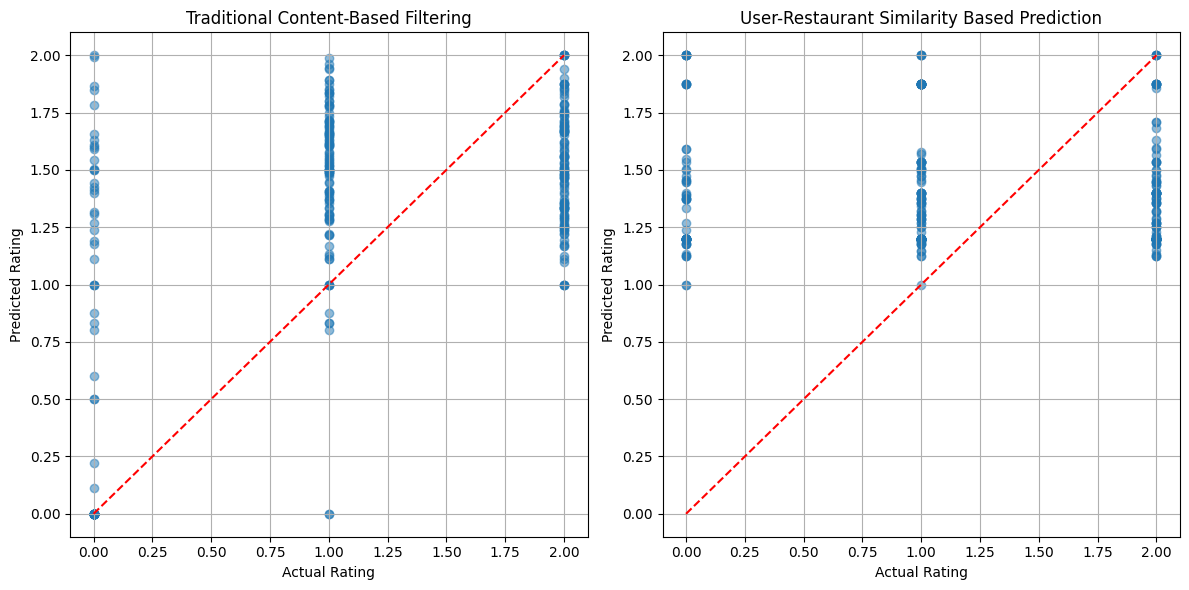

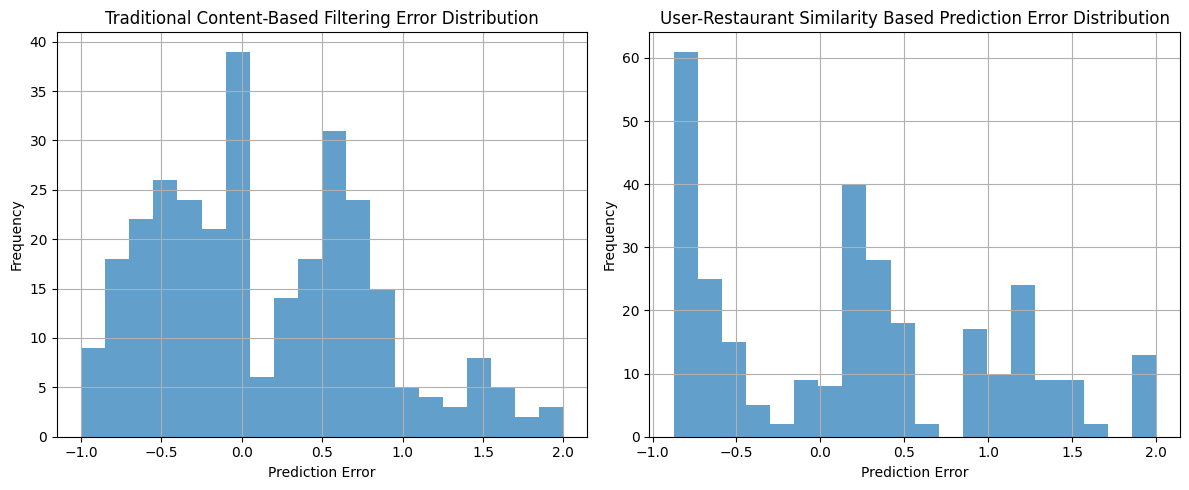

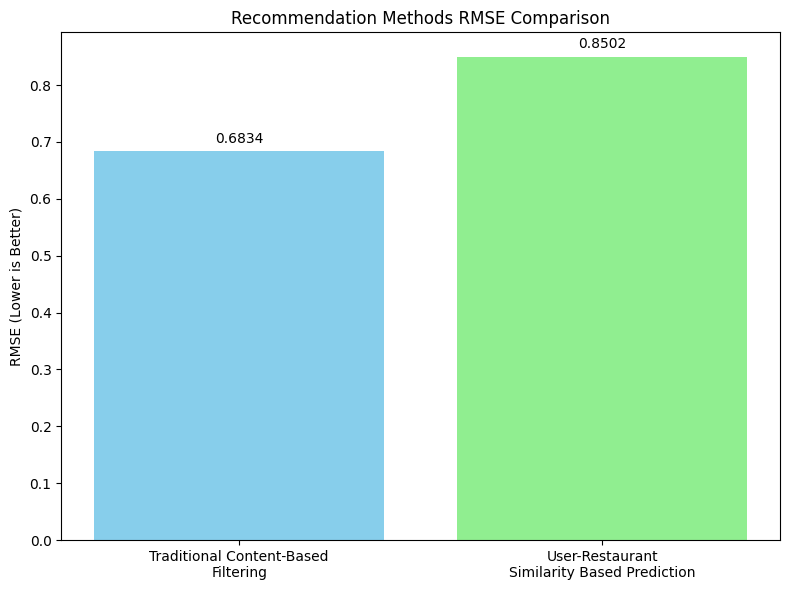

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

# 평점 데이터와 사용자, 식당 데이터는 이미 로드되어 있다고 가정 (rating, user, place)

# 1. 데이터 분할 (테스트셋 25%)
np.random.seed(42)
msk = np.random.rand(len(rating)) < 0.75
train_rating = rating[msk]
test_rating = rating[~msk]

print(f"Training data size: {len(train_rating)}, Test data size: {len(test_rating)}")

# 2. 전통적인 콘텐츠 기반 필터링 구현
def traditional_content_based_filtering(train_df, test_df, place_df):
    """
    Traditional content-based filtering implementation

    1. Find restaurants with high ratings for each user
    2. Create user preference profile based on these restaurants' features
    3. Calculate similarity between preference profile and all restaurants
    4. Generate predicted ratings based on similarity
    """
    # 장소 ID와 특성 데이터 준비
    place_ids = place_df['placeID'].values
    place_features = place_df.drop(columns=['placeID'], errors='ignore')

    # 결과 저장용 리스트
    predictions = []

    # 테스트셋의 각 사용자-식당 쌍에 대해 예측
    for _, row in test_df.iterrows():
        user_id = row['userID']
        target_place_id = row['placeID']
        actual_rating = row['rating']

        # 사용자가 훈련 데이터에서 평가한 식당들 찾기
        user_ratings = train_df[train_df['userID'] == user_id]

        if len(user_ratings) > 0:
            # 사용자 선호도 프로필 생성 (평점 >= 1.0인 식당의 특성 평균)
            liked_places = user_ratings[user_ratings['rating'] >= 1.0]['placeID'].values

            if len(liked_places) > 0:
                # 좋아하는 식당들의 인덱스 찾기
                liked_place_indices = [np.where(place_ids == p_id)[0][0] for p_id in liked_places if p_id in place_ids]

                if liked_place_indices:
                    # 선호하는 식당들의 특성 평균으로 사용자 선호도 프로필 생성
                    user_profile = place_features.iloc[liked_place_indices].mean().values.reshape(1, -1)

                    # 타겟 식당의 인덱스 찾기
                    if target_place_id in place_ids:
                        target_idx = np.where(place_ids == target_place_id)[0][0]
                        target_features = place_features.iloc[target_idx].values.reshape(1, -1)

                        # 선호도 프로필과 타겟 식당 간의 유사도 계산
                        similarity = cosine_similarity(user_profile, target_features)[0][0]

                        # 유사도를 0-2 범위의 예측 평점으로 변환
                        predicted_rating = (similarity + 1) * 1

                        predictions.append((user_id, target_place_id, actual_rating, predicted_rating))
                        continue

            # 선호 식당이 없거나, 타겟 식당이 없는 경우 평균 평점 사용
            avg_rating = user_ratings['rating'].mean()
            predictions.append((user_id, target_place_id, actual_rating, avg_rating))
        else:
            # 새 사용자는 전체 평균 사용
            global_avg = train_df['rating'].mean()
            predictions.append((user_id, target_place_id, actual_rating, global_avg))

    # 예측 결과를 데이터프레임으로 변환
    pred_df = pd.DataFrame(predictions, columns=['userID', 'placeID', 'actual', 'predicted'])

    # RMSE 계산
    mse = mean_squared_error(pred_df['actual'], pred_df['predicted'])
    rmse = sqrt(mse)

    return pred_df, rmse

# 3. 사용자-식당 코사인 유사도 기반 예측 구현
def user_place_similarity_prediction(test_df, user_df, place_df):
    """
    User-restaurant profile cosine similarity based prediction

    1. Prepare user and restaurant feature vectors
    2. Calculate cosine similarity
    3. Convert similarity to rating for prediction
    """
    # ID열 분리
    user_ids = user_df['userID'].values
    place_ids = place_df['placeID'].values

    # 특성열 가져오기
    user_features = user_df.drop(columns=['userID'], errors='ignore')
    place_features = place_df.drop(columns=['placeID'], errors='ignore')

    # 모든 고유한 열 이름 수집 및 누락된 열 추가
    all_columns = set(user_features.columns).union(set(place_features.columns))
    for col in all_columns:
        if col not in user_features.columns:
            user_features[col] = 0
        if col not in place_features.columns:
            place_features[col] = 0

    # 열 순서 맞추기
    sorted_columns = sorted(list(all_columns))
    user_features = user_features[sorted_columns]
    place_features = place_features[sorted_columns]

    # 결과 저장용 리스트
    predictions = []

    # 테스트셋의 각 사용자-식당 쌍에 대해 예측
    for _, row in test_df.iterrows():
        user_id = row['userID']
        place_id = row['placeID']
        actual_rating = row['rating']

        # 사용자와 식당의 인덱스 찾기
        if user_id in user_ids and place_id in place_ids:
            user_idx = np.where(user_ids == user_id)[0][0]
            place_idx = np.where(place_ids == place_id)[0][0]

            # 사용자와 식당의 특성 벡터 가져오기
            user_vector = user_features.iloc[user_idx].values.reshape(1, -1)
            place_vector = place_features.iloc[place_idx].values.reshape(1, -1)

            # 코사인 유사도 계산
            similarity = cosine_similarity(user_vector, place_vector)[0][0]

            # 유사도를 0-2 범위의 예측 평점으로 변환
            predicted_rating = (similarity + 1) * 1
        else:
            # 사용자나 식당이 없는 경우 글로벌 평균 사용
            predicted_rating = train_rating['rating'].mean()

        predictions.append((user_id, place_id, actual_rating, predicted_rating))

    # 예측 결과를 데이터프레임으로 변환
    pred_df = pd.DataFrame(predictions, columns=['userID', 'placeID', 'actual', 'predicted'])

    # RMSE 계산
    mse = mean_squared_error(pred_df['actual'], pred_df['predicted'])
    rmse = sqrt(mse)

    return pred_df, rmse

# 4. 두 방법 실행 및 비교
print("Performing traditional content-based filtering...")
content_based_pred, content_based_rmse = traditional_content_based_filtering(train_rating, test_rating, place)

print("Performing user-restaurant similarity based prediction...")
similarity_pred, similarity_rmse = user_place_similarity_prediction(test_rating, user, place)

# 5. 결과 시각화 및 비교
print("\n== Model Performance Comparison ==")
print(f"Traditional Content-Based Filtering RMSE: {content_based_rmse:.4f}")
print(f"User-Restaurant Similarity Based Prediction RMSE: {similarity_rmse:.4f}")

if content_based_rmse < similarity_rmse:
    print("\nConclusion: Traditional Content-Based Filtering shows better performance.")
    improvement = ((similarity_rmse - content_based_rmse) / similarity_rmse) * 100
    print(f"Performance improvement: {improvement:.2f}%")
else:
    print("\nConclusion: User-Restaurant Similarity Based Prediction shows better performance.")
    improvement = ((content_based_rmse - similarity_rmse) / content_based_rmse) * 100
    print(f"Performance improvement: {improvement:.2f}%")

# 예측 분포 비교 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(content_based_pred['actual'], content_based_pred['predicted'], alpha=0.5)
plt.plot([0, 2], [0, 2], 'r--')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Traditional Content-Based Filtering')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(similarity_pred['actual'], similarity_pred['predicted'], alpha=0.5)
plt.plot([0, 2], [0, 2], 'r--')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('User-Restaurant Similarity Based Prediction')
plt.grid(True)

plt.tight_layout()
plt.savefig('recommendation_approaches_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 오차 분포 비교
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
content_based_pred['error'] = content_based_pred['predicted'] - content_based_pred['actual']
plt.hist(content_based_pred['error'], bins=20, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Traditional Content-Based Filtering Error Distribution')
plt.grid(True)

plt.subplot(1, 2, 2)
similarity_pred['error'] = similarity_pred['predicted'] - similarity_pred['actual']
plt.hist(similarity_pred['error'], bins=20, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('User-Restaurant Similarity Based Prediction Error Distribution')
plt.grid(True)

plt.tight_layout()
plt.savefig('error_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# RMSE 비교 바 차트
plt.figure(figsize=(8, 6))
methods = ['Traditional Content-Based\nFiltering', 'User-Restaurant\nSimilarity Based Prediction']
rmse_values = [content_based_rmse, similarity_rmse]
bars = plt.bar(methods, rmse_values, color=['skyblue', 'lightgreen'])
plt.ylabel('RMSE (Lower is Better)')
plt.title('Recommendation Methods RMSE Comparison')

# 바 위에 RMSE 값 표시
for bar, rmse in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rmse:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('rmse_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

그냥 콘텐츠 기반 필터링이 더 정확함. 추후에 수집한 데이터로 테스트 해보고 같은 결과 나오면 콘텐츠 기반 필터링으로 변경